In [1]:
import Pkg
Pkg.activate(".")

  Activating new project at `~/ascr_ad/compression_tests/burgers_tests`


In [2]:
import CSV
import DataFrames

In [3]:
using Plots

In [4]:
function make_base_name(ad, nx)
    return "large_scale_burger_solution_$(ad)_n$(nx)"
end

function make_file_name(ad, nx)
    return make_base_name(ad, nx) * ".txt"
end

function parse_results_file(fname::AbstractString)

    mrstr = read(fname, String)

    memreg = r"Max. RSS: *([0-9]+\.[0-9]*) MiB"
    m = match(memreg, mrstr)
    mem_use = -1.0
    if m !== nothing
        mem_use = parse(Float64, m[1])
    end

    treg = r"Seconds: *([0-9]+\.[0-9]*)"
    m = match(treg, mrstr)
    time = -1.0
    if m !== nothing
        time = parse(Float64, m[1])
    end

    ncreg = r"Number of Calls: *([0-9]+)"
    m = match(ncreg, mrstr)
    ncalls = 0
    if m !== nothing
        ncalls = parse(Int, m[1])
    end

    creg = r"Converged: *([a-z]+)"
    m = match(creg, mrstr)
    converged = false
    if m !== nothing
        converged = parse(Bool, m[1])
    end

    # greg = r"Gradient Residual: (/[+\-]?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+\-]?\d+)?/)"
    greg = r"Gradient Residual: ([0-9\.+\-eE]+)"
    m = match(greg, mrstr)
    gres = -1.0
    if m !== nothing
        gres = parse(Float64, m[1])
    else
        error("Failed to find gradient residual!!")
    end

    # xreg = r"x Absolute Change: (/[+\-]?(?:0|[1-9]\d*)(?:\.\d+)?(?:[eE][+\-]?\d+)?/)"
    xreg = r"x Absolute Change: ([0-9\.+\-eE]+)"
    m = match(xreg, mrstr)
    xres = -1.0
    if m !== nothing
        xres = parse(Float64, m[1])
    else
        error("Failed to find x change residual!!")
    end
    
    return (mem_use, time, ncalls, converged, gres, xres)

end

function parse_memory_results_to_dataframe(
        rdir::AbstractString,
        ad_methods::Vector,
        grid_sizes::Vector
)

    my_ads = Vector{Symbol}()
    size = Vector{Int}()
    max_rss = Vector{Float64}()
    times = Vector{Float64}()
    ncalls = Vector{Int}()
    converged = Vector{Bool}()
    residuals = Vector{Float64}()
    xdeltas = Vector{Float64}()

    for ad in ad_methods
        for nx in grid_sizes
            fn = joinpath(rdir, make_file_name(ad, nx))
            (mr, tr, nc, cnv, res, dx) = parse_results_file(fn)
            push!(my_ads, ad)
            push!(size, nx)
            push!(max_rss, mr)
            push!(times, tr)            
            push!(ncalls, nc)
            push!(converged, cnv)
            push!(residuals, res)
            push!(xdeltas, dx)
        end
    end

    df = DataFrames.DataFrame(Dict(
            :AD => my_ads,
            :GridSize => size,
            :MaxRSS => max_rss,
            :Time => times,
            :NumCalls => ncalls,
            :Converged => converged,
            :Residual => residuals,
            :dx => xdeltas,
        ))
    return df

end

parse_memory_results_to_dataframe (generic function with 1 method)

In [5]:
results_dir = joinpath(@__DIR__, "results")
# ad_modes = [:forward, :reverse, :finitediff, :svdforward, :svdreverse]
ad_modes = [:forward, :reverse, :finitediff, :svdreverse]
grid_sizes = 2 .^ collect(4:10)
res_df = parse_memory_results_to_dataframe(results_dir, ad_modes, grid_sizes)
;

In [6]:
res_df

Row,AD,Converged,GridSize,MaxRSS,NumCalls,Residual,Time,dx
,Symbol,Bool,Int64,Float64,Int64,Float64,Float64,Float64
1,forward,true,16,928.266,275,1.25663,2.73868,1.11022e-16
2,forward,true,32,928.375,49,6.61988e-5,2.82262,0.000265426
3,forward,true,64,958.25,47,5.47592e-5,3.21942,0.000286292
4,forward,true,128,957.609,47,6.6184e-5,4.52615,0.000306012
5,forward,true,256,1032.7,42,6.857e-5,14.1046,0.000307719
6,forward,true,512,1111.97,33,6.62357e-5,60.001,0.00031591
7,forward,true,1024,1202.95,25,7.26586e-5,371.192,0.00025323
8,reverse,true,16,995.469,276,1.25663,4.05246,1.11022e-16
9,reverse,true,32,1120.88,49,6.61988e-5,4.23758,0.000265426


In [7]:
idx = res_df[:,:Converged] .== false
@show sum(idx)
;

sum(idx) = 0


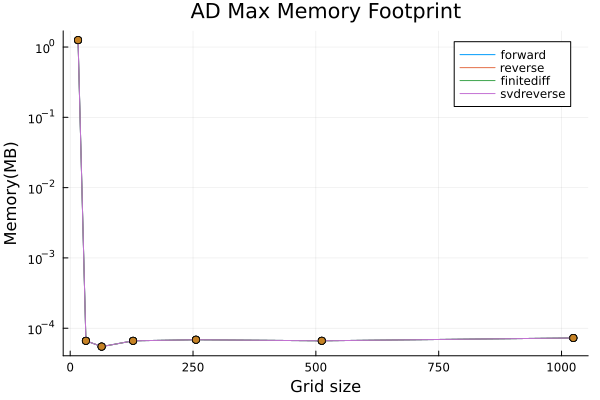

In [8]:
ad_df = DataFrames.groupby(res_df, :AD)
p = plot(;
    legend=true,
    title="AD Max Memory Footprint",
    ylabel="Memory(MB)",
    xlabel="Grid size",
    yscale=:log10,
    # xscale=:log10,
    # xticks=grid_sizes
)
for (k,df) in enumerate(ad_df)
    # println(df)
    method = df[1,:AD]
    grid_sizes = df[:,:GridSize]
    residuals = df[:,:Residual]
    plot!(p, grid_sizes, residuals, color=k, label=string(method))
    scatter!(p, grid_sizes, residuals, label=nothing)
end
display(p)

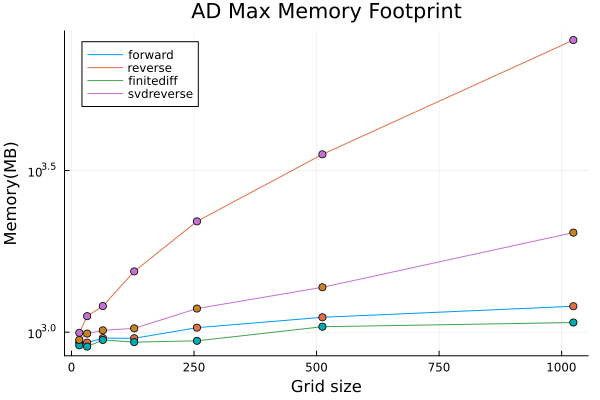

In [9]:
ad_df = DataFrames.groupby(res_df, :AD)
p = plot(;
    legend=true,
    title="AD Max Memory Footprint",
    ylabel="Memory(MB)",
    xlabel="Grid size",
    yscale=:log10,
    # xscale=:log10,
    # xticks=grid_sizes
)
for (k,df) in enumerate(ad_df)
    # println(df)
    method = df[1,:AD]
    grid_sizes = df[:,:GridSize]
    mem_res = df[:,:MaxRSS]
    plot!(p, grid_sizes, mem_res, color=k, label=string(method))
    scatter!(p, grid_sizes, mem_res, label=nothing)
end
display(p)

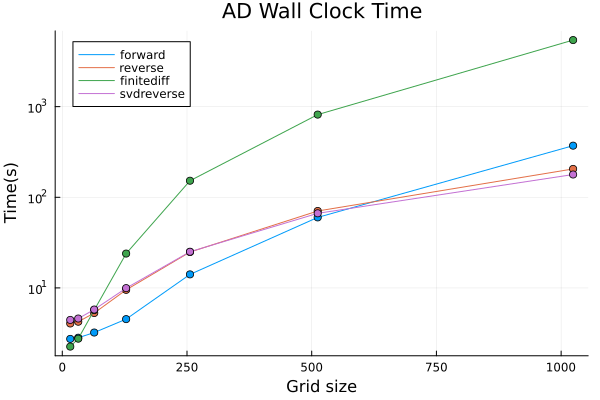

In [10]:
ad_df = DataFrames.groupby(res_df, :AD)
p = plot(;
    legend=true,
    title="AD Wall Clock Time",
    ylabel="Time(s)",
    xlabel="Grid size",
    yscale=:log10,
    # xscale=:log10,
    # xticks=grid_sizes
)
for (k,df) in enumerate(ad_df)
    # println(df)
    method = df[1,:AD]
    grid_sizes = df[:,:GridSize]
    times = df[:,:Time]
    plot!(p, grid_sizes, times, color=k, label=string(method))
    scatter!(p, grid_sizes, times, color=k, label=nothing)
end
display(p)

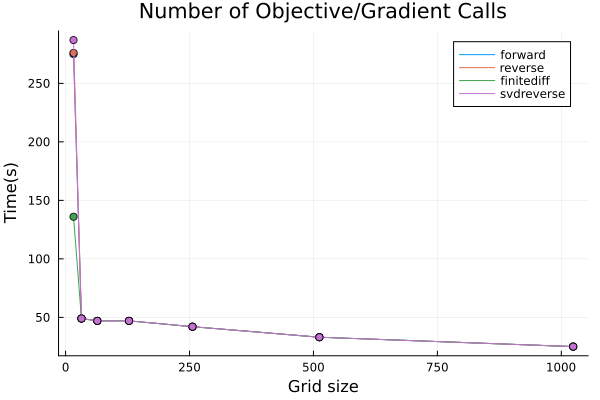

In [11]:
ad_df = DataFrames.groupby(res_df, :AD)
p = plot(;
    legend=true,
    title="Number of Objective/Gradient Calls",
    ylabel="Time(s)",
    xlabel="Grid size",
    # yscale=:log10,
    # xscale=:log10,
    # xticks=grid_sizes
)
for (k,df) in enumerate(ad_df)
    # println(df)
    method = df[1,:AD]
    grid_sizes = df[:,:GridSize]
    ncalls = df[:,:NumCalls]
    plot!(p, grid_sizes, ncalls, color=k, label=string(method))
    scatter!(p, grid_sizes, ncalls, color=k, label=nothing)
end
display(p)

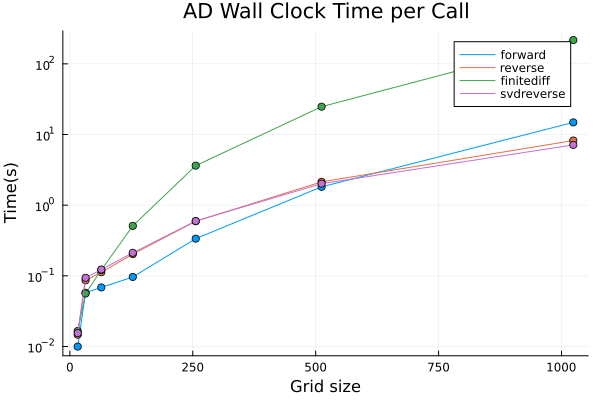

In [12]:
ad_df = DataFrames.groupby(res_df, :AD)
p = plot(;
    legend=true,
    title="AD Wall Clock Time per Call",
    ylabel="Time(s)",
    xlabel="Grid size",
    yscale=:log10,
    # xscale=:log10,
    # xticks=grid_sizes
)
for (k,df) in enumerate(ad_df)
    # println(df)
    method = df[1,:AD]
    grid_sizes = df[:,:GridSize]
    times = df[:,:Time] ./ df[:,:NumCalls]
    plot!(p, grid_sizes, times, color=k, label=string(method))
    scatter!(p, grid_sizes, times, color=k, label=nothing)
end
display(p)